# Comparison to the Water Budget
We compare the changes of our reconstructed water storage anomalies to the water balance, derived from ERA5.

In [1]:
import string

import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import xarray as xr
import cmcrameri.cm as cmc
from dask.diagnostics import ProgressBar
from matplotlib import ticker
from matplotlib_inline.backend_inline import set_matplotlib_formats

import deeprec  # noqa
from deeprec import metrics
from deeprec.regions import basins
from deeprec.utils import ROOT_DIR, repeat_by_weight

# Register dask progress bar
ProgressBar(minimum=5).register()


In [2]:
set_matplotlib_formats("retina")
plt.style.use(ROOT_DIR / "config/style_paper.mplstyle")
FIGURE_DIR = ROOT_DIR / "figures/paper"


## Data Loading

For preprocessing, see the corresponding notebook in `11-data-processing/water-budget-processing.ipynb`.

In [3]:
twsc_path = ROOT_DIR / "data/evaluations/twsc_basin-scale.zarr"
twsc = xr.open_zarr(twsc_path)


Specify variables of interest and their descriptive names:

In [4]:
vars_verbose = {
    "ours_era": "DeepRec (Ours)",
    "gap": "WGHM",
    "palazzoli_jpl_full": "Palazzoli's JPL Rec",
    "yin_csr_full": "Yin's CSR Rec",
    "li_csr_full": "Li's CSR Rec",
    "humphrey_gsfc_detrend": "Humphrey's GSFC Rec",
    "csr": "CSR (GRACE)",
}
bdgt_name = "era5_smooth"
grace_name = "csr"
our_name = "ours_era"
eval_names = vars_verbose.keys()


## Analysis

Define evaluation models and water balance target:

In [5]:
# Drop all time steps where one variable is NaN
twsc_post = twsc.where(twsc.dr.time_notnull("region"), drop=True)

bdgt_post = twsc_post[bdgt_name]
eval_post = twsc_post[eval_names].to_dataarray("model")

twsc_post


<xarray.Dataset> Size: 1MB
Dimensions:                (region: 72, time: 192)
Coordinates:
  * region                 (region) object 576B 'Amazon' 'Congo' ... 'Ural'
  * time                   (time) datetime64[ns] 2kB 2002-05-01 ... 2019-06-01
Data variables:
    csr                    (region, time) float64 111kB dask.array<chunksize=(72, 192), meta=np.ndarray>
    era5                   (region, time) float64 111kB dask.array<chunksize=(72, 192), meta=np.ndarray>
    era5_smooth            (region, time) float64 111kB dask.array<chunksize=(72, 192), meta=np.ndarray>
    gap                    (region, time) float64 111kB dask.array<chunksize=(72, 192), meta=np.ndarray>
    humphrey_gsfc_detrend  (region, time) float64 111kB dask.array<chunksize=(72, 192), meta=np.ndarray>
    li_csr_full            (region, time) float64 111kB dask.array<chunksize=(72, 192), meta=np.ndarray>
    ours_era               (region, time) float64 111kB dask.array<chunksize=(72, 192), meta=np.ndarray>
    ours_era-rdcd          (region, time) float64 111kB dask.array<chunksize=(72, 192), meta=np.ndarray>
    ours_wghm-era          (region, time) float64 111kB dask.array<chunksize=(72, 192), meta=np.ndarray>
    palazzoli_jpl_full     (region, time) float64 111kB dask.array<chunksize=(72, 192), meta=np.ndarray>
    yin_csr_full           (region, time) float64 111kB dask.array<chunksize=(72, 192), meta=np.ndarray>

In [6]:
twsc_pre = twsc.sel(time=slice("1980", "2001"))

bdgt_pre = twsc_pre[bdgt_name]
eval_pre = twsc_pre[eval_names].drop_vars(grace_name).to_dataarray("model")

twsc_pre


<xarray.Dataset> Size: 2MB
Dimensions:                (region: 72, time: 264)
Coordinates:
  * region                 (region) object 576B 'Amazon' 'Congo' ... 'Ural'
  * time                   (time) datetime64[ns] 2kB 1980-01-01 ... 2001-12-01
Data variables:
    csr                    (region, time) float64 152kB dask.array<chunksize=(72, 264), meta=np.ndarray>
    era5                   (region, time) float64 152kB dask.array<chunksize=(72, 264), meta=np.ndarray>
    era5_smooth            (region, time) float64 152kB dask.array<chunksize=(72, 264), meta=np.ndarray>
    gap                    (region, time) float64 152kB dask.array<chunksize=(72, 264), meta=np.ndarray>
    humphrey_gsfc_detrend  (region, time) float64 152kB dask.array<chunksize=(72, 264), meta=np.ndarray>
    li_csr_full            (region, time) float64 152kB dask.array<chunksize=(72, 264), meta=np.ndarray>
    ours_era               (region, time) float64 152kB dask.array<chunksize=(72, 264), meta=np.ndarray>
    ours_era-rdcd          (region, time) float64 152kB dask.array<chunksize=(72, 264), meta=np.ndarray>
    ours_wghm-era          (region, time) float64 152kB dask.array<chunksize=(72, 264), meta=np.ndarray>
    palazzoli_jpl_full     (region, time) float64 152kB dask.array<chunksize=(72, 264), meta=np.ndarray>
    yin_csr_full           (region, time) float64 152kB dask.array<chunksize=(72, 264), meta=np.ndarray>

###  Calculate RMSE

In [7]:
rmse_pre = metrics.rmse(bdgt_pre, eval_pre, dim="time").compute()
rmse_post = metrics.rmse(bdgt_post, eval_post, dim="time").compute()

# Select our reconstruction and GRACE
our_rmse_pre = rmse_pre.sel(model=our_name)
our_rmse_post = rmse_post.sel(model=our_name)
csr_rmse_post = rmse_post.sel(model=grace_name)


### Calculate NSE

In [8]:
nse_pre = metrics.nse(bdgt_pre, eval_pre, dim="time").compute()
nse_post = metrics.nse(bdgt_post, eval_post, dim="time").compute()

# Select our reconstruction and GRACE
our_nse_pre = nse_pre.sel(model=our_name)
our_nse_post = nse_post.sel(model=our_name)
csr_nse_post = nse_post.sel(model=grace_name)


## Create Plot

In [9]:
rmse_kwargs = dict(
    vmin=0,
    vmax=45,
    cmap=cmc.batlow_r,
    rasterized=True,
    coastlines=True,
    gridlines=True,
    coastlines_kwargs=dict(rasterized=True, linewidth=0.5),
    add_colorbar=False,
    cbar_kwargs=None,
)
nse_kwargs = dict(
    vmin=-1,
    vmax=1,
    cmap=cmc.bam,
    rasterized=True,
    coastlines=True,
    gridlines=True,
    coastlines_kwargs=dict(rasterized=True, linewidth=0.5),
    add_colorbar=False,
    cbar_kwargs=None,
)
basinlines_kwargs = dict(
    edgecolor="black",
    linewidth=0.3,
    facecolor="None",
    rasterized=True,
    zorder=3.0,
)
rmse_cbar_kwargs = dict(location="bottom", aspect=50, shrink=0.66)
nse_cbar_kwargs = dict(location="bottom", aspect=50, shrink=0.66, extend="min")


In [10]:
# Get timespan
start = eval_post.get_index("time")[0]
end = eval_post.get_index("time")[-1]
timespan_str = f"{start.year}-{start.month:02} - {end.year}-{end.month:02}"
timespan_str


'2002-05 - 2019-06'

In [11]:
# Create a spatial dummy array for the .dr.projplot_basins() function
STEP_DEG = 0.5
lats = np.arange(-89.75, 89.75 + STEP_DEG, STEP_DEG)
lons = np.arange(-179.75, 179.75 + STEP_DEG, STEP_DEG)

ones = np.ones([len(lats), len(lons)])

spatial_dummy = xr.DataArray(ones, coords={"lat": lats, "lon": lons})


In [12]:
# GeoDataFrame containing basin shapes and areas
gdf_basin_shapes = basins(top=72)

# Series of basin areas, for scatter plotting
s_basin_areas = gdf_basin_shapes.rename(
    columns={"riverbasin": "region", "sum_sub_ar": "area"}
).set_index("region")["area"]

# DataArray of basin areas, for weighting
da_basin_areas = xr.DataArray.from_series(s_basin_areas)

In [13]:
print(f"{our_rmse_pre.min() = :.2f}")
print(f"{our_rmse_pre.max() = :.2f}\n")

print(f"{our_rmse_post.min() = :.2f}")
print(f"{our_rmse_post.max() = :.2f}\n")

print(f"{our_rmse_pre.weighted(da_basin_areas).mean() = :.2f}")
print(f"{our_rmse_pre.weighted(da_basin_areas).quantile(0.9) = :.2f}\n")

print(f"{our_rmse_post.weighted(da_basin_areas).mean() = :.2f}")
print(f"{our_rmse_post.weighted(da_basin_areas).quantile(0.9) = :.2f}\n")


our_rmse_pre.min() = 4.54
our_rmse_pre.max() = 39.07

our_rmse_post.min() = 3.45
our_rmse_post.max() = 41.10

our_rmse_pre.weighted(da_basin_areas).mean() = 12.23
our_rmse_pre.weighted(da_basin_areas).quantile(0.9) = 29.46

our_rmse_post.weighted(da_basin_areas).mean() = 12.12
our_rmse_post.weighted(da_basin_areas).quantile(0.9) = 30.46



In [14]:
print(f"{our_nse_pre.min() = :.2f}")
print(f"{our_nse_pre.max() = :.2f}\n")

print(f"{our_nse_post.min() = :.2f}")
print(f"{our_nse_post.max() = :.2f}\n")

print(f"{our_nse_pre.weighted(da_basin_areas).mean() = :.2f}")
print(f"{our_nse_pre.weighted(da_basin_areas).quantile(0.9) = :.2f}\n")

print(f"{our_nse_post.weighted(da_basin_areas).mean() = :.2f}")
print(f"{our_nse_post.weighted(da_basin_areas).quantile(0.9) = :.2f}\n")

our_nse_pre.min() = -1.00
our_nse_pre.max() = 0.96

our_nse_post.min() = -1.89
our_nse_post.max() = 0.97

our_nse_pre.weighted(da_basin_areas).mean() = 0.54
our_nse_pre.weighted(da_basin_areas).quantile(0.9) = 0.93

our_nse_post.weighted(da_basin_areas).mean() = 0.55
our_nse_post.weighted(da_basin_areas).quantile(0.9) = 0.94



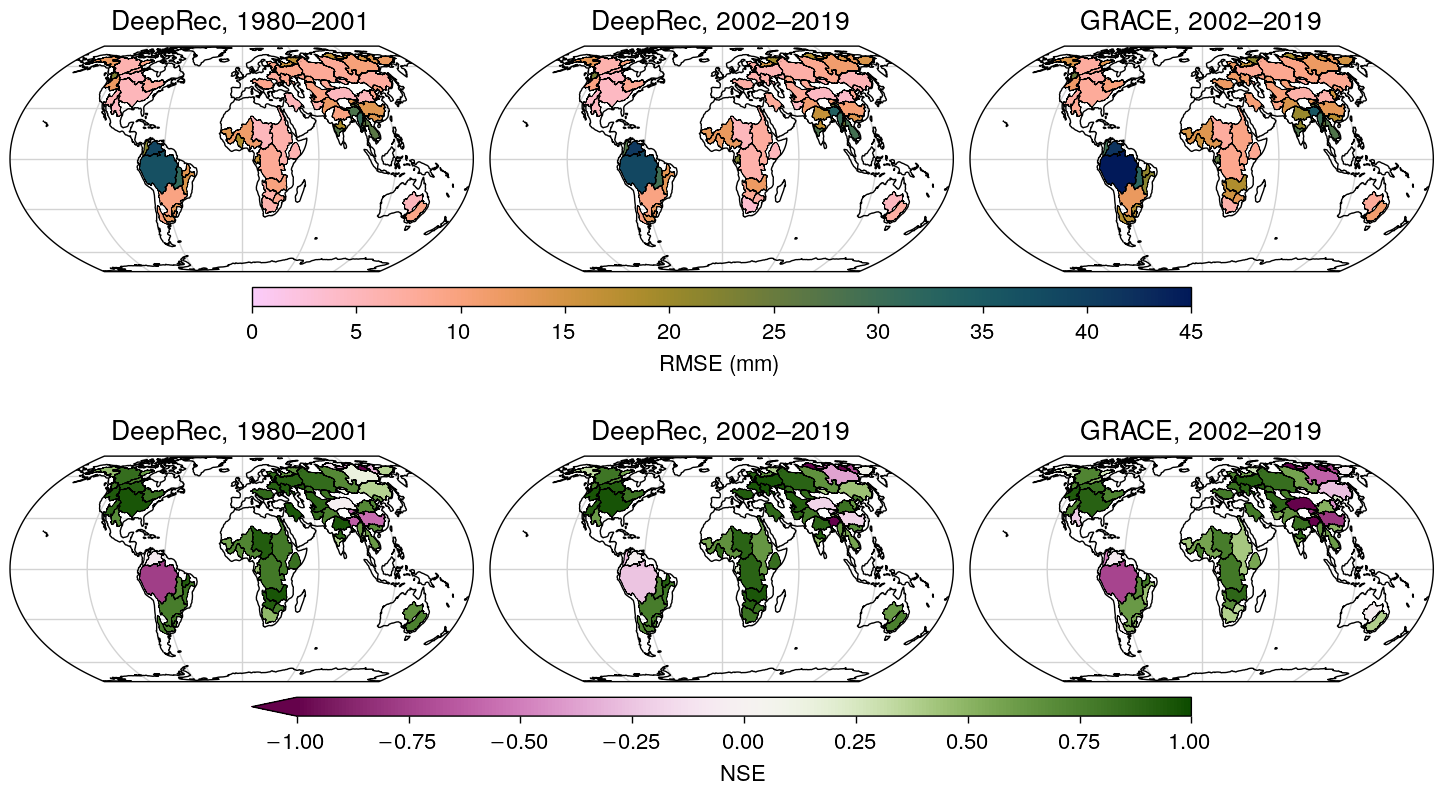

In [15]:
# Subfigure approach
fig = plt.figure(figsize=(7.2, 4))
subfigs = fig.subfigures(nrows=2, hspace=0.05)

axs_rmse = subfigs[0].subplots(1, 3, subplot_kw={"projection": ccrs.EqualEarth()})
axs_nse = subfigs[1].subplots(1, 3, subplot_kw={"projection": ccrs.EqualEarth()})

axs_geo = [*axs_rmse, *axs_nse]

# RMSE Ours Pre-GRACE
p_rmse = our_rmse_pre.dr.projplot_basins(spatial_dummy, ax=axs_rmse[0], **rmse_kwargs)
axs_rmse[0].set(title="DeepRec, 1980--2001")

# RMSE Ours GRACE era
our_rmse_post.dr.projplot_basins(spatial_dummy, ax=axs_rmse[1], **rmse_kwargs)
axs_rmse[1].set(title="DeepRec, 2002--2019")

# RMSE GRACE
csr_rmse_post.dr.projplot_basins(spatial_dummy, ax=axs_rmse[2], **rmse_kwargs)
axs_rmse[2].set(title="GRACE, 2002--2019")

# NSE Ours Pre-GRACE
p_nse = our_nse_pre.dr.projplot_basins(spatial_dummy, ax=axs_nse[0], **nse_kwargs)
axs_nse[0].set(title="DeepRec, 1980--2001")

# NSE Ours GRACE era
our_nse_post.dr.projplot_basins(spatial_dummy, ax=axs_nse[1], **nse_kwargs)
axs_nse[1].set(title="DeepRec, 2002--2019")

# NSE GRACE
csr_nse_post.dr.projplot_basins(spatial_dummy, ax=axs_nse[2], **nse_kwargs)
axs_nse[2].set(title="GRACE, 2002--2019")

for ax in axs_geo:
    # Add basinlines
    gdf_basin_shapes.dr.projplot(ax=ax, **basinlines_kwargs)

# Add colorbars
subfigs[0].colorbar(p_rmse, ax=axs_rmse, label="RMSE (mm)", **rmse_cbar_kwargs)
subfigs[0].colorbar(p_nse, ax=axs_nse, label="NSE", **nse_cbar_kwargs);


## Weighted Boxplot: Ability to close the water budget

We calculate the error between the reconstructed TWSC and the ERA5 TWSC (the budget). We plot the basin wise errors as a boxplot, whereby we weight the basins according to their approximate size.

In [16]:
# Create DataArrays for the models to evaluate and the budget
da_eval = twsc[eval_names].to_dataarray("model")
da_bdgt = twsc[bdgt_name]


Create a DataFrame with an integer column where the number is relative to the the basin area. Our weighting function requires integer values.

In [17]:
# Create a DataFrame with the basin shape areas
basin_sizes = gdf_basin_shapes[["riverbasin", "sum_sub_ar"]].rename(
    columns={"riverbasin": "region", "sum_sub_ar": "area"}
)
# Smallest int equals multiplier (specifies accuracy fo the weighting)
MULT = 10
area_rel = basin_sizes.area / basin_sizes.area.min() * MULT
basin_sizes["area_int"] = area_rel.round().astype(int)
basin_sizes


,region,area,area_int
0,Amazon,5965893.5,283
1,Congo,3705225.4,176
2,Nile,3353204.0,159
3,Mississippi,3240620.1,154
4,Ob,3040604.1,144
...,...,...,...
67,Har,229005.7,11
68,Liao,220125.2,10
69,Olenek,217723.1,10
70,Ogooue,215213.0,10


### Create the boxplot

Evaluation logic: Only evaluate time steps which are available for every model. This is achieved in the following way:
1. Split time series into 20 year validation periods
2. For each validation period, exclude products which are mostly unavailable (have less than 80 % valid time steps). This filters out Humphrey and Li which start in 1979.
3. Exclude time steps from evaluation which are invalid in any of the remaining *valid* products. This way, the evaluated time steps are consistent across all products.

In [18]:
colors = sns.color_palette("tab10")
colors


[(0.12156862745098039, 0.4666666666666667, 0.7058823529411765),
 (1.0, 0.4980392156862745, 0.054901960784313725),
 (0.17254901960784313, 0.6274509803921569, 0.17254901960784313),
 (0.8392156862745098, 0.15294117647058825, 0.1568627450980392),
 (0.5803921568627451, 0.403921568627451, 0.7411764705882353),
 (0.5490196078431373, 0.33725490196078434, 0.29411764705882354),
 (0.8901960784313725, 0.4666666666666667, 0.7607843137254902),
 (0.4980392156862745, 0.4980392156862745, 0.4980392156862745),
 (0.7372549019607844, 0.7411764705882353, 0.13333333333333333),
 (0.09019607843137255, 0.7450980392156863, 0.8117647058823529)]

In [19]:
# Create dictionaries for color lookup
colors_dict = {
    "ours_era": colors[0],
    "csr": colors[1],
    "gap": colors[2],
    "palazzoli_jpl_full": colors[3],
    "yin_csr_full": colors[4],
    "li_csr_full": colors[5],
    "humphrey_gsfc_detrend": colors[6],
}


In [20]:
# Time periods for calculating basin wise errors
TIME_PERIODS = [
    ("1940", "1959"),
    ("1960", "1979"),
    ("1980", "2001"),
    ("2002", "2019"),
]


In [21]:
THRES = 0.8

# DataFrame of the weighted basin RMSEs for every period
df_errors = []

# Evaluated periods after NaN cleaning
time_periods_eval = []

for period in TIME_PERIODS:
    # Select current time period
    da_bdgt_period = da_bdgt.sel(time=slice(*period))
    da_eval_period = da_eval.sel(time=slice(*period))
    # Logic to remove model if less time steps than specified threshold are
    # available during the evaluated period
    n_time = len(da_eval_period.time)
    valid_models = list(da_eval_period.model.values)
    for model in da_eval_period.model.values:
        # Drop model if less not-NA timesteps than threshold for current period
        n_time_notna = len(
            da_eval_period.sel(model=model).dropna("time", how="all").time
        )
        if n_time_notna < THRES * n_time:
            # Effectively hides model for the given period
            da_eval_period = da_eval_period.where(da_eval_period.model != model)
            # Remove model from valid models
            valid_models.remove(model)
    # Do not consider time steps which are NA for at least one valid model
    is_valid_time = da_eval_period.sel(model=valid_models).notnull().all("model")
    da_true_period = da_bdgt_period.where(is_valid_time)
    # Calculate the RMSE
    da_error = metrics.rmse(da_bdgt_period, da_eval_period, dim="time", skipna=True)
    # Convert to data frame
    df_error = da_error.to_pandas().unstack().reset_index(name="error")
    # Merge with basin frame
    df_error = df_error.merge(basin_sizes)
    # Add decriptive names
    df_error["model_verbose"] = df_error["model"].map(vars_verbose)
    # Save evaluated period
    times_eval = da_true_period.dropna("time").get_index("time")
    time_periods_eval.append((times_eval[0].year, times_eval[-1].year))
    # Repeat rows according to the basin size
    df_error = repeat_by_weight(df_error, weight_col="area_int")

    df_errors.append(df_error)


In [22]:
time_periods_eval

[(1941, 1959), (1960, 1979), (1984, 2001), (2002, 2019)]

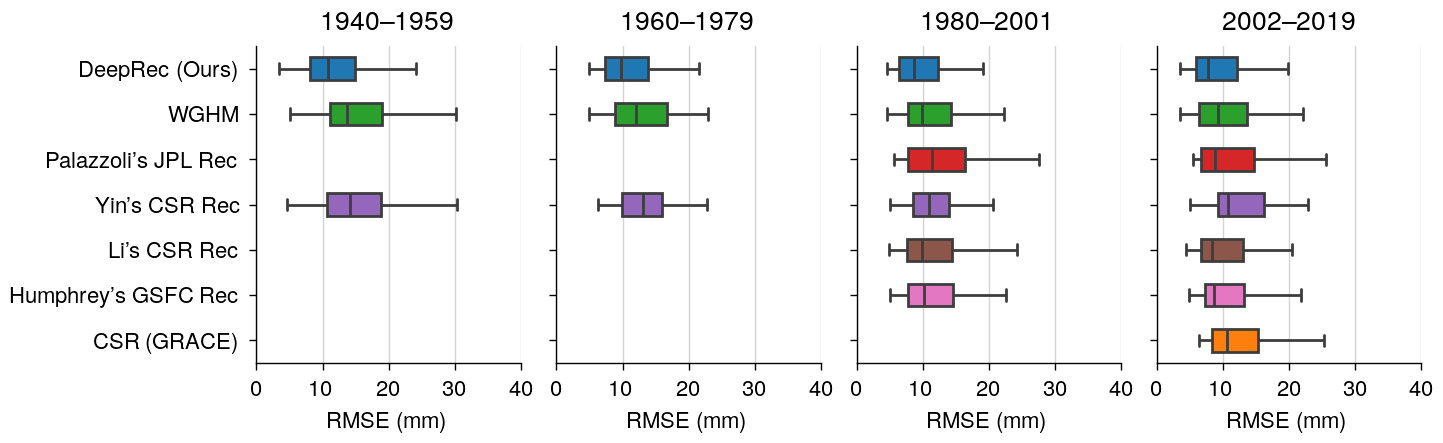

In [23]:
# Create boxplots
fig, axs = plt.subplots(
    ncols=len(TIME_PERIODS), sharex=True, sharey=True, figsize=(7.2, 2.2)
)
locator = ticker.MultipleLocator(10)

# Iterate over different time periods
for ax, period, df_error in zip(axs, TIME_PERIODS, df_errors):
    # Plot
    sns.boxplot(
        df_error,
        x="error",
        y="model_verbose",
        hue="model",
        palette=colors_dict,
        showfliers=False,
        width=0.5,
        saturation=1,
        legend=False,
        ax=ax,
    )
    ax.xaxis.grid()
    ax.set(xlabel="RMSE (mm)", ylabel=None)
    ax.set_title(period[0] + "--" + period[1])
    ax.xaxis.set_major_locator(locator)

axs[0].set(xlim=(0, 40));


Switch x and y axis, use color-coded legend instead of categorical axis labels:

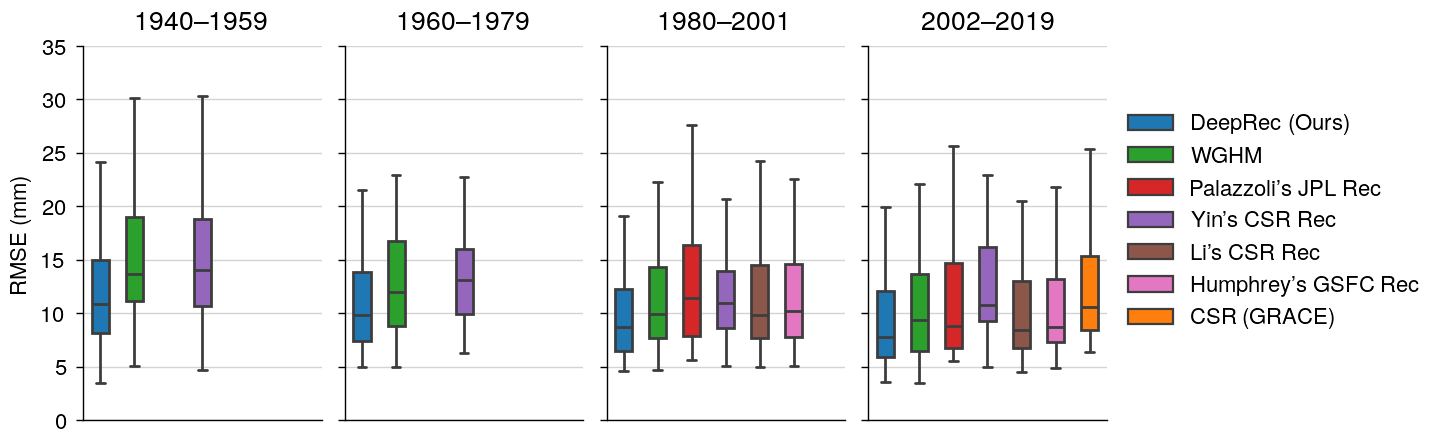

In [24]:
# Create boxplots
fig, axs = plt.subplots(
    ncols=len(TIME_PERIODS), sharex=True, sharey=True, figsize=(7.2, 2.2)
)
# Iterate over different time periods
for i, (ax, period, df_error) in enumerate(zip(axs, TIME_PERIODS, df_errors)):
    # Plot
    sns.boxplot(
        df_error,
        x="model_verbose",
        y="error",
        hue="model",
        palette=colors_dict,
        showfliers=False,
        width=0.5,
        saturation=1,
        legend=True if i == 3 else False,
        ax=ax,
    )
    ax.yaxis.grid()
    ax.set(ylabel="RMSE (mm)", xlabel=None)
    ax.set_title(period[0] + "--" + period[1])
    ax.xaxis.set_visible(False)

axs[0].set(ylim=(0, 35))

# Move legend outside the axes
leg = fig.legend(loc="outside right")
for text in leg.texts:
    text.set_text(vars_verbose[text.get_text()])
axs[-1].legend().remove()

## Combine Everything

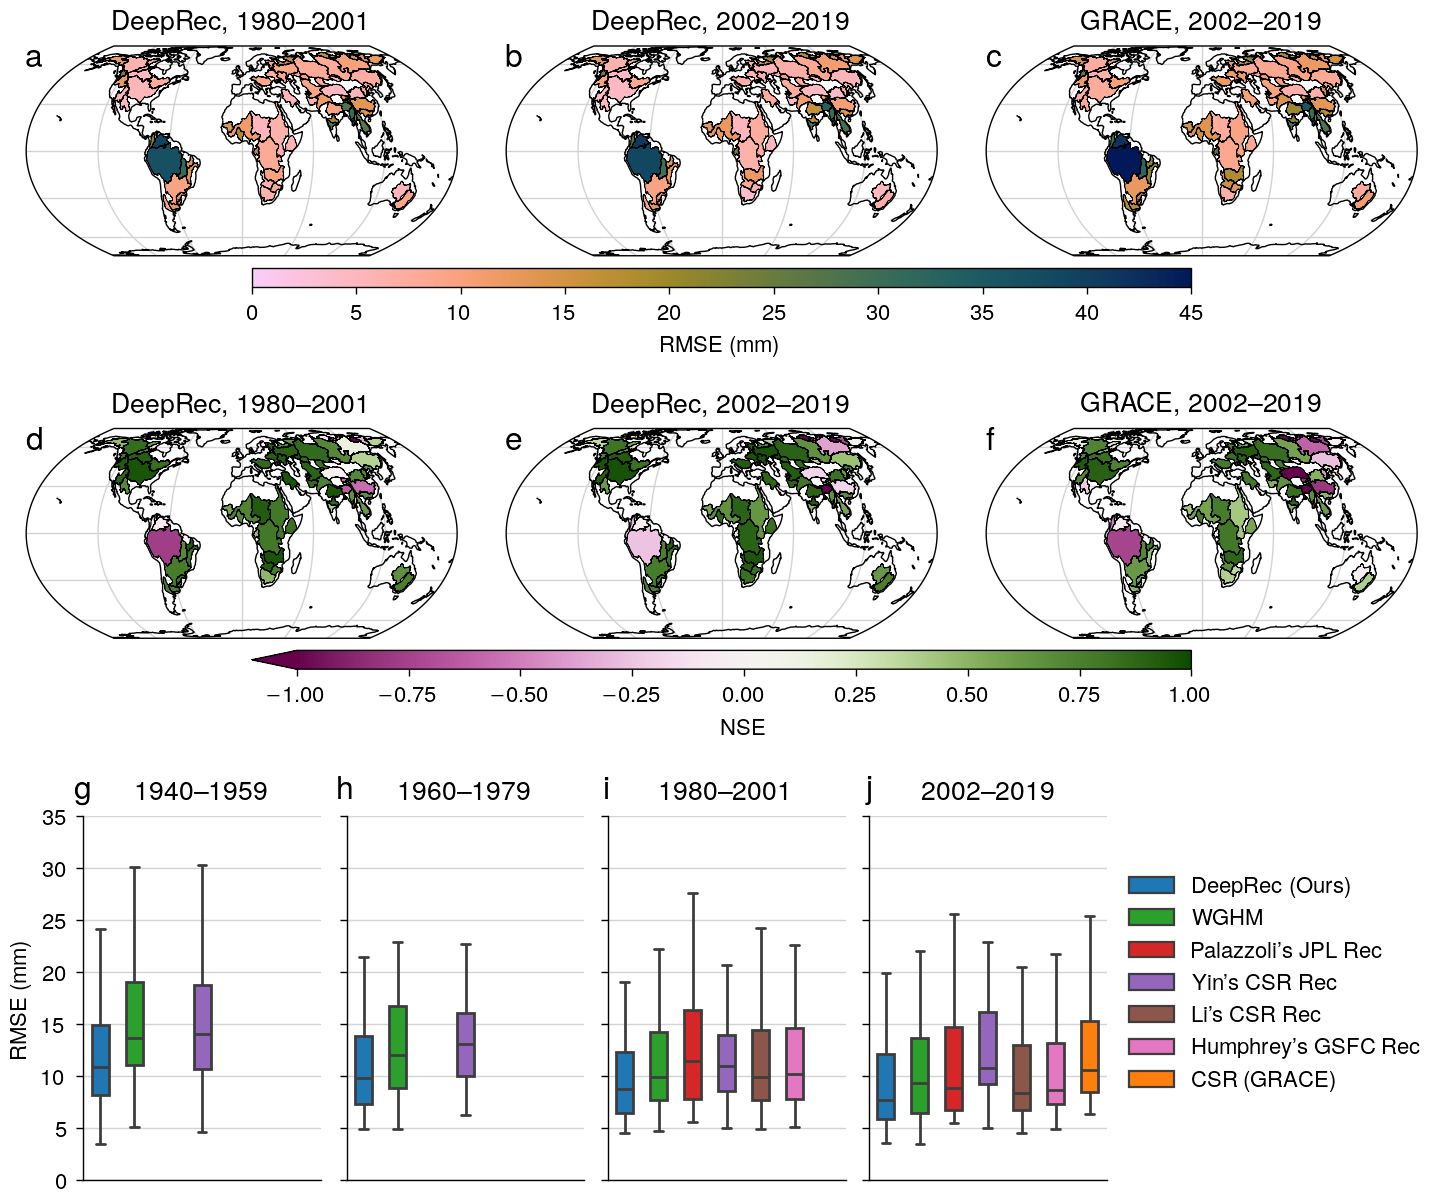

In [25]:
# Subfigure approach
fig = plt.figure(figsize=(7.2, 6))
subfigs = fig.subfigures(nrows=3, hspace=0.05, height_ratios=[1, 1, 1.2])

axs_rmse = subfigs[0].subplots(1, 3, subplot_kw={"projection": ccrs.EqualEarth()})
axs_nse = subfigs[1].subplots(1, 3, subplot_kw={"projection": ccrs.EqualEarth()})
axs_box = subfigs[2].subplots(1, 4, sharex=True, sharey=True)


### MAP PLOTS ###

axs_geo = [*axs_rmse, *axs_nse]

# RMSE Ours Pre-GRACE
p_rmse = our_rmse_pre.dr.projplot_basins(spatial_dummy, ax=axs_rmse[0], **rmse_kwargs)
axs_rmse[0].set(title="DeepRec, 1980--2001")

# RMSE Ours GRACE era
our_rmse_post.dr.projplot_basins(spatial_dummy, ax=axs_rmse[1], **rmse_kwargs)
axs_rmse[1].set(title="DeepRec, 2002--2019")

# RMSE GRACE
csr_rmse_post.dr.projplot_basins(spatial_dummy, ax=axs_rmse[2], **rmse_kwargs)
axs_rmse[2].set(title="GRACE, 2002--2019")

# NSE Ours Pre-GRACE
p_nse = our_nse_pre.dr.projplot_basins(spatial_dummy, ax=axs_nse[0], **nse_kwargs)
axs_nse[0].set(title="DeepRec, 1980--2001")

# NSE Ours GRACE era
our_nse_post.dr.projplot_basins(spatial_dummy, ax=axs_nse[1], **nse_kwargs)
axs_nse[1].set(title="DeepRec, 2002--2019")

# NSE GRACE
csr_nse_post.dr.projplot_basins(spatial_dummy, ax=axs_nse[2], **nse_kwargs)
axs_nse[2].set(title="GRACE, 2002--2019")

for ax in axs_geo:
    # Add basinlines
    gdf_basin_shapes.dr.projplot(ax=ax, **basinlines_kwargs)

# Add colorbars
subfigs[0].colorbar(p_rmse, ax=axs_rmse, label="RMSE (mm)", **rmse_cbar_kwargs)
subfigs[0].colorbar(p_nse, ax=axs_nse, label="NSE", **nse_cbar_kwargs)


### BOXPLOTS ###

locator = ticker.MultipleLocator(10)

# Iterate over different time periods
for i, (ax, period, df_error) in enumerate(zip(axs_box, TIME_PERIODS, df_errors)):
    # Plot
    sns.boxplot(
        df_error,
        x="model_verbose",
        y="error",
        hue="model",
        palette=colors_dict,
        showfliers=False,
        width=0.5,
        saturation=1,
        ax=ax,
        legend=True if i == 3 else False,
    )
    ax.set(ylabel="RMSE (mm)", xlabel=None)
    ax.set_title(period[0] + "--" + period[1])
    ax.xaxis.set_visible(False)
    ax.yaxis.grid()

axs_box[0].set(ylim=(0, 35))

# Move legend outside the axes
leg = subfigs[2].legend(loc="outside right")
for text in leg.texts:
    text.set_text(vars_verbose[text.get_text()])
axs_box[3].legend().remove()

### LETTERS ###

for n, ax in enumerate(axs_geo):
    ax.text(
        0.0,
        1.0 - 0.10,
        string.ascii_lowercase[n],
        transform=ax.transAxes,
        size="x-large",
        weight="bold",
    )
for n, ax in enumerate(axs_box):
    ax.text(
        0.0,
        1.0 + 0.05,
        string.ascii_lowercase[n + len(axs_geo)],
        ha="center",
        transform=ax.transAxes,
        size="x-large",
        weight="bold",
    )

fig.savefig(FIGURE_DIR / "bdgt_closure.pdf", backend="pgf")
